In [4]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import librosa.display
import librosa
import pickle

In [ ]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

In [5]:
optimizer = tf.keras.optimizers.Adam(0.0001)
latent_dim = 128
sr = 48000
sr16k = 16000
fx = ["Clean", "TubeScreamer", "BluesDriver", "RAT", "Chorus", "Phaser", "Flanger", "Tape Echo","Sweep Echo", "Digital Delay", "Hall Reverb", "PlateReverb", "Spring Reverb"]

In [3]:
# mount your Google drive so that you only have to download the data only once
#from google.colab import drive
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [24]:
######load your data#######
from natsort import natsorted
import os
from os import walk
import numpy as np
# load your data
paths = [
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Clean",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/TubeScreamer",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/BluesDriver",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/RAT",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Chorus",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Phaser",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Flanger",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/TapeEcho",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Sweep Echo",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Digital Delay",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Hall Reverb",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Plate Reverb",
         "/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/Spring Reverb",
         
         ]
#print(paths)
audios = []
labels = []
labelsname = []
for i in paths:
    for (dirpath, dirnames, filenames) in walk(i):
      #print(dirpath)
      for directory in dirpath:
        for filename in filenames:
          if filename.endswith("wav"):
            #print(filename)
            audios.append(os.path.join(dirpath, filename))
        break
print(len(audios))

audios = natsorted(audios)

8970


In [2]:
#audios = [audios[i] for i in range(0,len(audios),10)]
print(len(audios))

8970


In [ ]:
'''''''''
###rawwaveform###
waveforms = []

for track in audios:
  if track.endswith("wav"):
    y,fs = librosa.load(track)
    waveforms.append(librosa.resample(y[:sr], sr, sr16k))
waveforms = np.array(waveforms)
print(waveforms.shape)

In [ ]:
with open('''waveforms.pkl''', 'rb') as f:
  waveforms = pickle.load(f)

In [ ]:
###normalizar y cambio de dimensionalidad
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]

Xw = (waveforms-mu_wave)/max_wave
print(Xw.shape)

In [ ]:
#####reshape de los datos
Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

In [ ]:
####AUTOENCODER
optimizer = tf.keras.optimizers.Adam(0.0001)
latent_dim = 128
original_dim = (sr16k, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (33,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(33,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(33,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(512,(33,1), activation="relu", padding="same",strides=(3,1))(x)
encoder_flat = layers.Flatten()(x)
latent = layers.Dense(latent_dim, activation='relu')(encoder_flat)

encoder = keras.Model(encoder_inputs, latent, name="encoder")
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16000, 1, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4000, 1, 64)       2176      
                                                                 
 conv2d_5 (Conv2D)           (None, 1000, 1, 128)      270464    
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 1, 256)       1081600   
                                                                 
 conv2d_7 (Conv2D)           (None, 84, 1, 512)        4325888   
                                                                 
 flatten_1 (Flatten)         (None, 43008)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               5505

In [ ]:
latent_inputs = keras.Input(latent_dim)
x = layers.Dense(250 * 1 * 512, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 512))(x)
x = layers.Conv2DTranspose(128,(33,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(33,1), activation="relu",padding= "same",strides= (4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (33, 1), activation="tanh", padding="same", strides = (4,1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="AE")

decoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 128000)            16512000  
                                                                 
 reshape_1 (Reshape)         (None, 250, 1, 512)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 1000, 1, 128)     2162816   
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 4000, 1, 64)      270400    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16000, 1, 1)      2113     

In [ ]:
salida = decoder(encoder(encoder_inputs)) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
ae = Model(inputs=encoder_inputs, outputs= salida, name='AE-Model')
ae.compile(optimizer= optimizer,loss = 'mean_squared_error')


In [ ]:
tr_logs = ae.fit(Xw,Xw, shuffle = True, batch_size= 5, epochs= 100)

Epoch 1/100
1380/1380 [==============================] - 49s 35ms/step - loss: 0.1131
Epoch 2/100
1380/1380 [==============================] - 50s 36ms/step - loss: 0.1108
Epoch 3/100
1380/1380 [==============================] - 50s 36ms/step - loss: 0.1079
Epoch 4/100
1380/1380 [==============================] - 48s 34ms/step - loss: 0.1041
Epoch 5/100
1380/1380 [==============================] - 48s 35ms/step - loss: 0.0987
Epoch 6/100
1380/1380 [==============================] - 48s 35ms/step - loss: 0.0950
Epoch 7/100
1380/1380 [==============================] - 48s 35ms/step - loss: 0.0933
Epoch 8/100
1380/1380 [==============================] - 48s 35ms/step - loss: 0.0911
Epoch 9/100
1380/1380 [==============================] - 48s 35ms/step - loss: 0.0898
Epoch 10/100
1380/1380 [==============================] - 48s 35ms/step - loss: 0.0871
Epoch 11/100
1380/1380 [==============================] - 48s 35ms/step - loss: 0.0840
Epoch 12/100
1380/1380 [============================

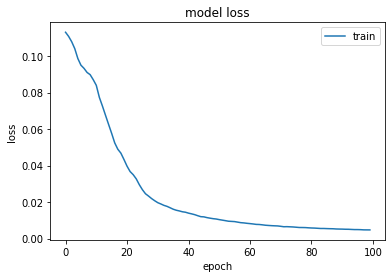

In [ ]:
#######LOSS
plt.plot(tr_logs.history['loss'])
#plt.plot(tr_logs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
ae_latent = encoder.predict(Xw)
#print(ae_latent)

In [ ]:
###visualización PCA
fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig)#,elev=-0, azim= 0)
#X_reduced = PCA(n_components=3).fit_transform(X)

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 3)

# "transform" the data that you want to reduce to "two components"
X_PCA = pca.fit_transform(ae_latent)

ax.scatter3D(X_PCA[:68, 0], X_PCA[:68, 1],X_PCA[:68, 2], c='red', label='BluesDriver')
ax.scatter3D(X_PCA[69:137, 0], X_PCA[69:137, 1],X_PCA[69:137, 2], c='green', label='Chorus')
ax.scatter3D(X_PCA[138:206, 0], X_PCA[138:206, 1],X_PCA[138:206, 2], c='blue', label='Clean')
ax.scatter3D(X_PCA[207:275, 0], X_PCA[207:275, 1],X_PCA[207:275, 2], c='red', label='Digital Delay')
ax.scatter3D(X_PCA[276:344, 0], X_PCA[276:344, 1],X_PCA[276:344, 2], c='yellow', label= 'Flanger')
ax.scatter3D(X_PCA[345:413, 0], X_PCA[345:413, 1],X_PCA[345:413, 2], c='black', label='Phaser')
ax.scatter3D(X_PCA[414:482, 0], X_PCA[414:482, 1],X_PCA[414:482, 2], c='white', label='RAT')
ax.scatter3D(X_PCA[483:551, 0], X_PCA[483:551, 1],X_PCA[483:551, 2], c='orange', label='Sweep Echo')
ax.scatter3D(X_PCA[552:620, 0], X_PCA[552:620, 1],X_PCA[552:620, 2], c='pink', label='TapeEcho')
ax.scatter3D(X_PCA[621:689, 0], X_PCA[621:689, 1],X_PCA[621:689, 2], c='brown', label='TubeScreamer')

plt.legend()
plt.title('Analisis de componentes Principales "2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

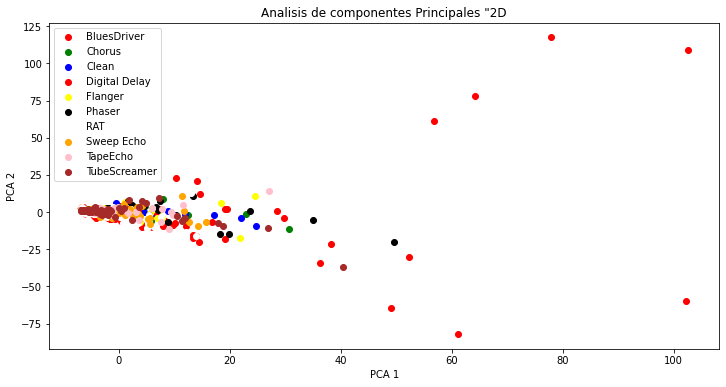

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 2)

# "transform" the data that you want to reduce to "two components"
X_PCA = pca.fit_transform(ae_latent)

plt.scatter(X_PCA[:68, 0], X_PCA[:68, 1], c='red', label='BluesDriver')
plt.scatter(X_PCA[69:137, 0], X_PCA[69:137, 1], c='green', label='Chorus')
plt.scatter(X_PCA[138:206, 0], X_PCA[138:206, 1], c='blue', label='Clean')
plt.scatter(X_PCA[207:275, 0], X_PCA[207:275, 1], c='red', label= 'Digital Delay')
plt.scatter(X_PCA[276:344, 0], X_PCA[276:344, 1], c='yellow', label= 'Flanger')
plt.scatter(X_PCA[345:413, 0], X_PCA[345:413, 1], c='black', label= 'Phaser')
plt.scatter(X_PCA[414:482, 0], X_PCA[414:482, 1], c='white', label= 'RAT')
plt.scatter(X_PCA[483:551, 0], X_PCA[483:551, 1], c='orange', label= 'Sweep Echo')
plt.scatter(X_PCA[552:620, 0], X_PCA[552:620, 1], c='pink', label= 'TapeEcho')
plt.scatter(X_PCA[621:689, 0], X_PCA[621:689, 1], c='brown', label= 'TubeScreamer')

plt.legend()
plt.title('Analisis de componentes Principales "2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

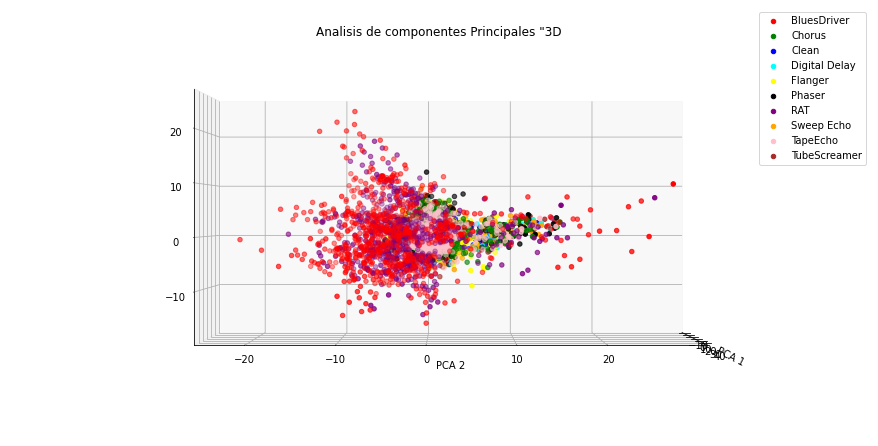

In [ ]:
###visualización PCA 3D #########
###visualización PCA 3D #########
###visualización PCA 3D #########

fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig,elev=-0, azim=0)
pca = PCA(n_components= 3)
X_PCA = pca.fit_transform(ae_latent)

ax.scatter3D(X_PCA[:689, 0], X_PCA[:689, 1],X_PCA[:689, 2], c='red', label='BluesDriver')
ax.scatter3D(X_PCA[690:1379, 0], X_PCA[690:1379, 1],X_PCA[690:1379, 2], c='green', label='Chorus')
ax.scatter3D(X_PCA[1380:2069, 0], X_PCA[1380:2069, 1],X_PCA[1380:2069, 2], c='blue', label='Clean')
ax.scatter3D(X_PCA[2070:2759, 0], X_PCA[2070:2759, 1],X_PCA[2070:2759, 2], c='cyan', label='Digital Delay')
ax.scatter3D(X_PCA[2760:3449, 0], X_PCA[2760:3449, 1],X_PCA[2760:3449, 2], c='yellow', label='Flanger')
ax.scatter3D(X_PCA[3450:4139, 0], X_PCA[3450:4139, 1],X_PCA[3450:4139, 2], c='black', label='Phaser')
ax.scatter3D(X_PCA[4140:4829, 0], X_PCA[4140:4829, 1],X_PCA[4140:4829, 2], c='purple', label='RAT')
ax.scatter3D(X_PCA[4830:5519, 0], X_PCA[4830:5519, 1],X_PCA[4830:5519, 2], c='orange', label= 'Sweep Echo')
ax.scatter3D(X_PCA[5520:6209, 0], X_PCA[5520:6209, 1],X_PCA[5520:6209, 2], c='pink', label='TapeEcho')
ax.scatter3D(X_PCA[6210:6899, 0], X_PCA[6210:6899, 1],X_PCA[6210:6899, 2], c='brown', label='TubeScreamer')

plt.legend()
plt.title('Analisis de componentes Principales "3D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.zlabel('PCA 3')

plt.show()

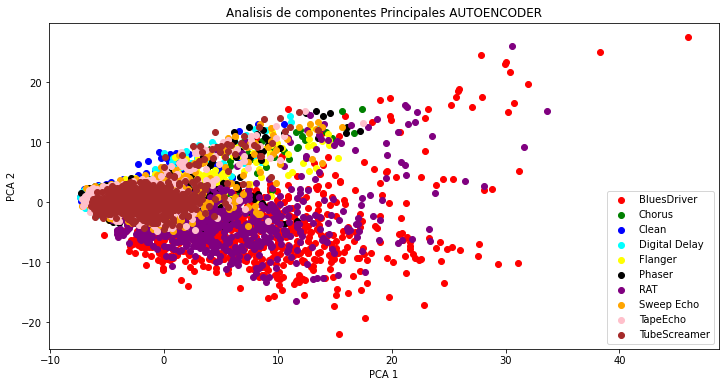

In [ ]:
#####PCA 2D ##########
#####PCA 2D ##########
#####PCA 2D ##########

fig = plt.figure(1, figsize=(12, 6))
pca = PCA(n_components= 2)
X_PCA = pca.fit_transform(ae_latent)

plt.scatter(X_PCA[:689, 0], X_PCA[:689, 1], c='red', label= 'BluesDriver')
plt.scatter(X_PCA[690:1379, 0], X_PCA[690:1379, 1], c='green', label= 'Chorus')
plt.scatter(X_PCA[1380:2069, 0], X_PCA[1380:2069, 1], c='blue', label= 'Clean')
plt.scatter(X_PCA[2070:2759, 0], X_PCA[2070:2759, 1], c='cyan', label= 'Digital Delay')
plt.scatter(X_PCA[2760:3449, 0], X_PCA[2760:3449, 1], c='yellow', label= 'Flanger')
plt.scatter(X_PCA[3450:4139, 0], X_PCA[3450:4139, 1], c='black', label= 'Phaser')
plt.scatter(X_PCA[4140:4829, 0], X_PCA[4140:4829, 1], c='purple', label= 'RAT')
plt.scatter(X_PCA[4830:5519, 0], X_PCA[4830:5519, 1], c='orange', label= 'Sweep Echo')
plt.scatter(X_PCA[5520:6209, 0], X_PCA[5520:6209, 1], c='pink', label= 'TapeEcho')
plt.scatter(X_PCA[6210:6899, 0], X_PCA[6210:6899, 1], c='brown', label= 'TubeScreamer')

plt.legend()
plt.title('Analisis de componentes Principales AUTOENCODER')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
#########     ################
#########     ################
######### VAE ################
#########     ################

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    #@tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean = np.array([input[0]])
        #z_log_var = np.array([input[1]])
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1+ log_var - K.square(mu) - K.exp(log_var))

In [7]:
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(0.0001)

In [8]:
latent_dim = 128
original_dim = (sr16k, 1, 1)
encoder_inputs = keras.Input((16000, 1, 1))                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (33,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(33,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(33,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(33,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
vae_encoder.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-29 09:48:14.913128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 09:48:14.913250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "encoder_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16000, 1, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 4000, 1, 64)  2176        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1000, 1, 128  270464      ['conv2d[0][0]']                 
                                )                                                                 
                                                                                        

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(33,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(33,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (33, 1), activation="tanh", padding="same", strides = (4,1))(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
vae_decoder.summary()

Model: "decoder_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 64000)             8256000   
                                                                 
 reshape (Reshape)           (None, 250, 1, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1000, 1, 128)     1081472   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4000, 1, 64)      270400    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16000, 1, 1)      

In [11]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = vae_decoder(vae_encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

In [ ]:
vae_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'SampledGuitar/Stratocaster/vae_check/checkpoint',    # the location where we will save the checkpoint file 
    save_weights_only = True,                
    monitor='loss',
    mode='min',
    save_best_only=True
)

vae_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor= "loss",
    min_delta= 0,
    patience= 50,
    verbose= 0,
    mode= "auto",
    baseline= None,
    restore_best_weights= False,
)

In [ ]:
tr_logs = vae.fit(Xw,Xw, shuffle = True, batch_size= 5, epochs= 400, callbacks= [vae_checkpoint,vae_earlystop])

Epoch 1/400
1794/1794 [==============================] - 40s 22ms/step - loss: 0.0986
Epoch 2/400
1794/1794 [==============================] - 40s 22ms/step - loss: 0.0982
Epoch 3/400
1794/1794 [==============================] - 40s 23ms/step - loss: 0.0953
Epoch 4/400
1794/1794 [==============================] - 40s 22ms/step - loss: 0.0890
Epoch 5/400
1794/1794 [==============================] - 40s 22ms/step - loss: 0.0828
Epoch 6/400
1794/1794 [==============================] - 41s 23ms/step - loss: 0.0778
Epoch 7/400
1794/1794 [==============================] - 40s 22ms/step - loss: 0.0717
Epoch 8/400
1794/1794 [==============================] - 40s 23ms/step - loss: 0.0646
Epoch 9/400
1794/1794 [==============================] - 40s 23ms/step - loss: 0.0567
Epoch 10/400
1794/1794 [==============================] - 40s 23ms/step - loss: 0.0520
Epoch 11/400
1794/1794 [==============================] - 41s 23ms/step - loss: 0.0481
Epoch 12/400
1794/1794 [============================

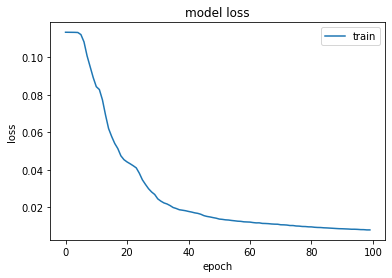

In [ ]:
plt.plot(tr_logs.history['loss'])
#plt.plot(tr_logs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
#vae.save('SampledGuitar/Stratocaster/vae_model/vae_model.h5')

In [1]:
vae.load_weights('/Users/mezaga93/guitar_VAE-1/checkpoints')
acc= vae.evaluate(Xw, Xw)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

NameError: name 'vae' is not defined

In [ ]:
##get the latent space mean, sigma, z
latent = vae_encoder.predict(Xw)

In [ ]:
print(latent[0].shape)

(6900, 128)


In [ ]:
y_hat = vae.predict(Xw)

In [ ]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

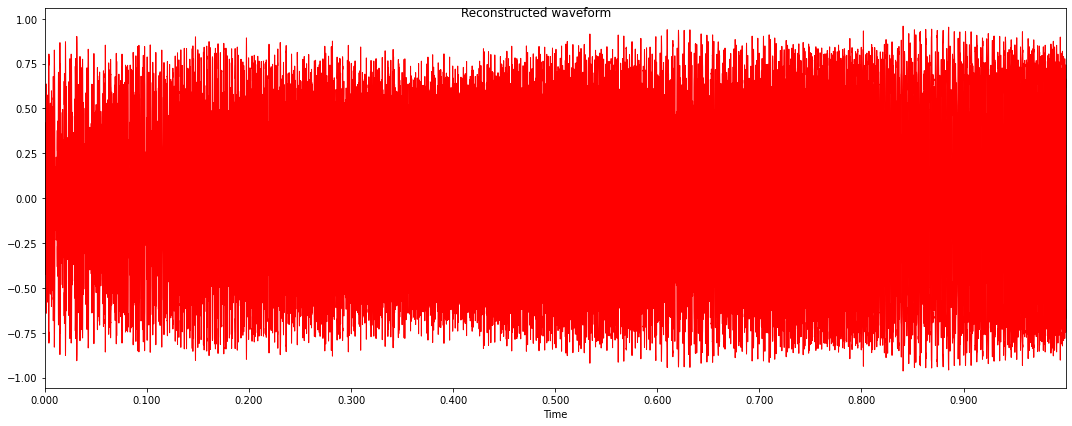

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
 
plt.figure(figsize=(15, 6)).suptitle("Reconstructed waveform")
librosa.display.waveshow(y_hat[668].flatten(),sr= sr16k, color='r')
plt.tight_layout()
plt.show()

In [ ]:
#print(sonidos)
Audio(y_hat[668].flatten(), sr16k)

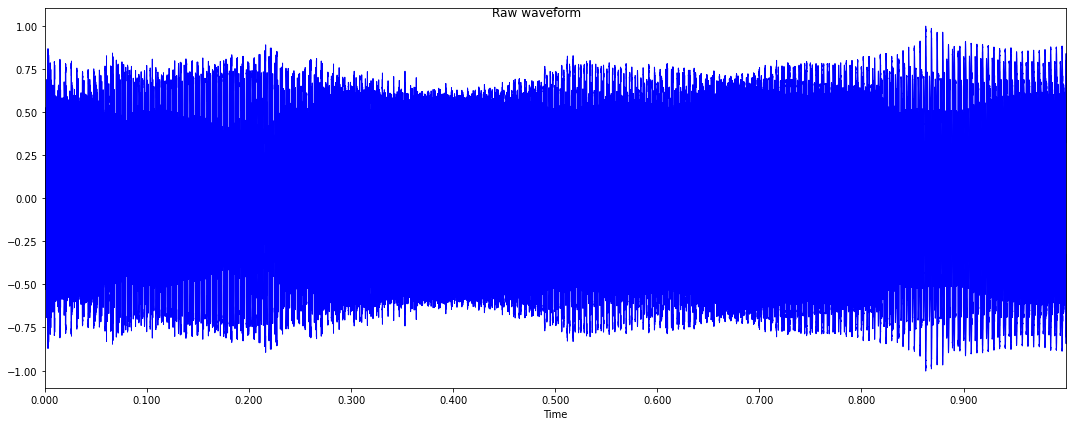

In [ ]:

plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
librosa.display.waveshow(Xw[668].flatten(),sr= sr16k, color='b')
plt.tight_layout()
plt.show()

In [ ]:
Audio(Xw[668].flatten(),sr16k)

NameError: name 'y_hat' is not defined

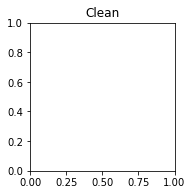

In [6]:
####visualización de los audios antes de normalizar
plt.figure(figsize=(15, 6))
sonidos = [i * 690 for i in range(10)]
for i, x in enumerate(sonidos):
    plt.subplot(2, 5, i+ 1).set_title(fx[i])
    librosa.display.waveshow(y_hat[x].flatten(),color='r')
plt.tight_layout()
plt.title("Waveforms")
plt.show()

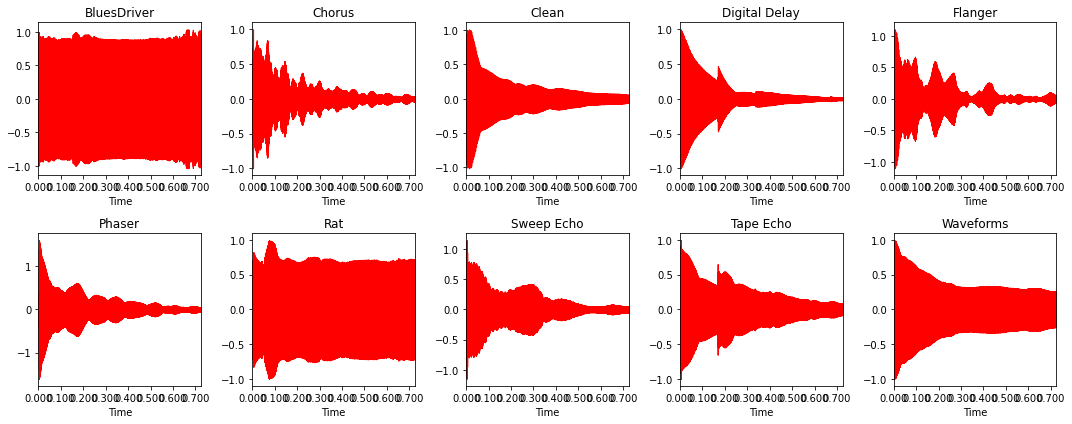

In [ ]:
plt.figure(figsize=(15, 6))
sonidos = [i * 690 for i in range(10)]
for i, x in enumerate(sonidos):
    plt.subplot(2, 5, i+ 1).set_title(fx[i])
    librosa.display.waveshow(Xw[x].flatten(), color='r')
plt.tight_layout()
plt.title("Waveforms")
plt.show()

In [ ]:
########################## sampling ###########################
print(latent[0][2][0])
print(latent[0][3][0])

created = (latent[0][2]) +(latent[0][2]- latent[0][3])
print(created)
#gen = np.linspace(-20,50,sr16k)
#print(gen)

In [ ]:
import numpy as np
def latent_inter(audio_a, audio_b, step = 1):
  'step hace referencia al numero de audios entre las referencias'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step + 1, endpoint=False).flatten()
  else:
    listas = np.linspace(audio_a, audio_b, step + 1, endpoint=False)
  return listas[1:]

In [ ]:
#audiosgen = latent_inter(latent[0][0], latent[0][690], 2)

<class 'numpy.ndarray'>


In [ ]:
primero = 668
segundo = 668 + 690
gen_audio = 10
gen_latent = latent_inter(latent[0][primero],latent[0][segundo],gen_audio)


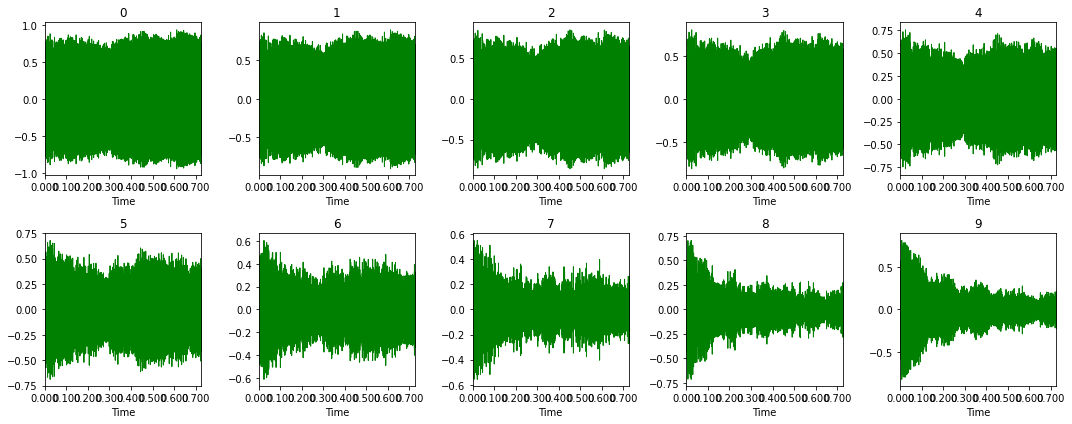

In [ ]:
gen_latent = vae_decoder.predict(latent_inter(latent[0][primero],latent[0][segundo],gen_audio))
v = [gen_latent[i].flatten() for i in range(gen_audio)]
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(gen_audio):
    plt.subplot(2, 5, i+ 1).set_title(i)
    librosa.display.waveshow(v[i], color='green')
plt.tight_layout()
#plt.title()
plt.show()


In [ ]:
Audio(v[9],sr16k)

In [ ]:
v_wave = np.mean(v, axis= 1)[...,np.newaxis]
v_max_wave = np.max(v, axis=1)[...,np.newaxis]

v = (v- v_wave)/v_max_wave

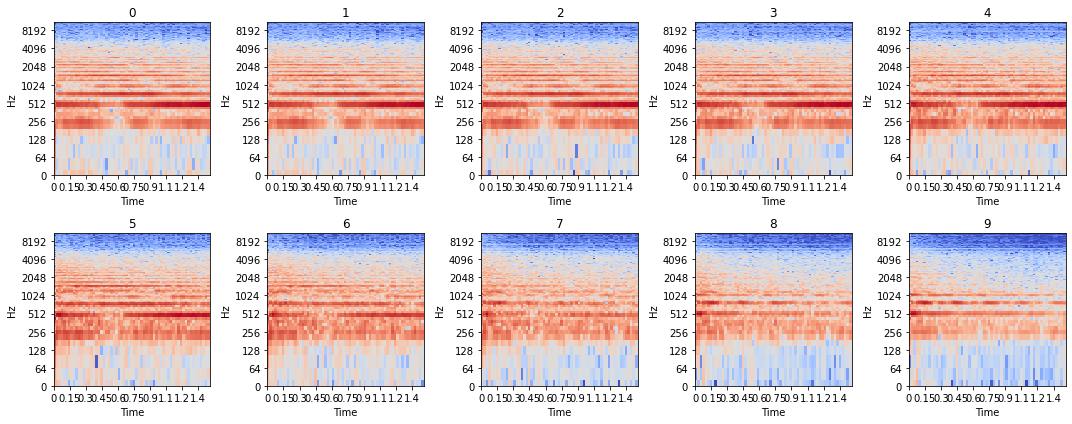

In [ ]:
plt.figure(figsize=(15, 6))#.suptitle("STFT Data")
plt.title('stft')

for i in range(gen_audio):
    plt.subplot(2, 5, i + 1).set_title(i)
    stft = librosa.stft(v[i], n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft))
    librosa.display.specshow(stft, y_axis='log', x_axis='time')
plt.tight_layout()

plt.show()

In [ ]:
def euclidean_distance(array1,array2):
    dist = np.linalg.norm(array1 - array2)
    return dist

In [ ]:
def latent_sonidos_near(k, matriz, n):
    lista = []
    for j,array in enumerate(matriz):
        a = euclidean_distance(k, array)
        lista.append(a)
    idx = np.argpartition(lista, n)
    result = [matriz[i] for i in idx[:n]]
    return result

In [ ]:
print(latent_sonidos_near(b, x, 3))